# RDD Design

Measure the effect of sending emails to customers on their movie ticket purchases.

@roman

09/08/25

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uuid

import statsmodels.api as sm
import statsmodels.formula.api as smf
import holidays

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, classification_report
from catboost import CatBoostClassifier, Pool
import shap

---
# Data

## Read

In [2]:
# read data
df_transactions = pd.read_csv("../data/Transactions.csv", header=0)
df_pricebook = pd.read_csv("../data/Pricebook.csv", header=0)
df_customers = pd.read_csv("../data/Customers.csv", header=0)
df_emails = pd.read_csv("../data/Emails.csv", header=0)
df_releases = pd.read_csv("../data/Releases.csv", header=0, sep="|")

# print shapes
print(f"Transactions shape: {df_transactions.shape}")
print(f"Pricebook shape: {df_pricebook.shape}")
print(f"Customers shape: {df_customers.shape}")
print(f"Emails shape: {df_emails.shape}")
print(f"Releases shape: {df_releases.shape}")

Transactions shape: (329580, 8)
Pricebook shape: (103, 2)
Customers shape: (5718369, 2)
Emails shape: (1864512, 3)
Releases shape: (412, 3)


## Wrangle

### Transactions

In [3]:
# create uuid for each transaction based on CARD_MEMBERSHIPID & FECHA_TRANSACCION & FECHA_FUNCION
df_transactions['transaction_id'] = df_transactions.apply(
    lambda x: str(uuid.uuid5(uuid.NAMESPACE_DNS, str(x['CARD_MEMBERSHIPID']) + '_' + str(x['FECHA_TRANSACCION']) + '_' + str(x['FECHA_FUNCION']))),
    axis=1
)

# remove boletos that are 0
df_transactions = df_transactions.query('BOLETOS > 0').reset_index(drop=True)

# remove transactoins that are IMPORTE_TAQUILLA <= 0
df_transactions = df_transactions.query('IMPORTE_TAQUILLA > 0').reset_index(drop=True)

# agg transactions by id
df_transactions = (
    df_transactions
    .groupby('transaction_id', as_index=False)
    .agg({
        'ID_CINE': 'first',
        'FECHA_TRANSACCION': 'first',
        'FECHA_FUNCION': 'first',
        'CARD_MEMBERSHIPID': 'first',
        'ID_MARCA': 'first',
        'TX_PELICULA_UNICA': 'first',
        'BOLETOS': 'sum',
        'IMPORTE_TAQUILLA': 'sum'
    })
    .reset_index(drop=True)
    # FECHA_TRANSACCION and FECHA_FUNCION as datetime
    .assign(
        FECHA_TRANSACCION=lambda x: pd.to_datetime(x['FECHA_TRANSACCION'], format='%Y-%m-%d', errors='coerce'),
        FECHA_FUNCION=lambda x: pd.to_datetime(x['FECHA_FUNCION'], format='%Y-%m-%d', errors='coerce')
    )
    .sort_values(by='FECHA_TRANSACCION', ascending=True, ignore_index=True)
)

# look
print(f"Transactions shape after cleaning: {df_transactions.shape}")
df_transactions.head()

Transactions shape after cleaning: (304196, 9)


,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA
0,9610a0e3-a813-5c2f-a25a-9ba3b3e033fa,234,2024-01-01,2024-01-01,49026ebf4714f93dcb5f9ae0230c4d4f9afb424d1c23da...,1,AQUAMAN Y EL REINO PERDIDO,2,82.0
1,01984a03-5ec3-54e0-8696-d4622a181411,154,2024-01-01,2024-01-01,df624cc8bc0be3e8cb3de3522bf0f2728f6a88b5fe451e...,1,GODZILLA MINUS ONE,1,70.0
2,7b45b02a-a47b-506d-878a-79fde2bf8821,273,2024-01-01,2024-01-01,dc8f5462dfa0b2f78e04d6ae96f2bb597a7725c24a0b4a...,1,AQUAMAN Y EL REINO PERDIDO,2,82.0
3,8e9b0dc9-56f3-57c7-991d-f588c9712b7c,260,2024-01-01,2024-01-01,60b3ba400a6d9671cfe62a7114e415eae0e1af4e1ce738...,1,WONKA,2,82.0
4,eabdde26-84fd-58fb-8cc0-9fe46a839e57,273,2024-01-01,2024-01-02,2a81492ebbbdf24a683736eddd436e9430d43101acbdf4...,1,AQUAMAN Y EL REINO PERDIDO,2,170.0


In [4]:
# now look
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304196 entries, 0 to 304195
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     304196 non-null  object        
 1   ID_CINE            304196 non-null  int64         
 2   FECHA_TRANSACCION  304196 non-null  datetime64[ns]
 3   FECHA_FUNCION      304196 non-null  datetime64[ns]
 4   CARD_MEMBERSHIPID  304196 non-null  object        
 5   ID_MARCA           304196 non-null  int64         
 6   TX_PELICULA_UNICA  304196 non-null  object        
 7   BOLETOS            304196 non-null  int64         
 8   IMPORTE_TAQUILLA   304196 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 20.9+ MB


### Emails

In [5]:
# merge emails with customers (get a semi-join)
df_emails = (
    df_emails
    .merge(df_customers, how='inner', left_on="SubscriberKeyH", right_on="SubscriberKey")
    .reset_index(drop=True)
    .drop(columns=["SubscriberKeyH", "SubscriberKey"])
    .reset_index(drop=True)
)

# look
print(df_emails.shape)
df_emails.head()

(478492, 3)


,EventDate,SendId,CARD_MEMBERSHIPID
0,2023-11-29T13:47:54.000Z,1446643,742d12444044a3e9bb1a2cf6366a655a2d3c6aaf129ae4...
1,2023-11-29T13:47:54.000Z,1446643,77469b9f0de8821ab678101074b4807419df2ac676922a...
2,2023-11-29T13:47:56.000Z,1446643,ed5ba01b5c83153c264e40d0d402b180f8ac4479eac62b...
3,2023-11-29T13:48:37.000Z,1446643,3fea058c49be5e3d22c004c1dfe0ec6b191d37529c452b...
4,2023-11-29T11:45:14.000Z,1446629,d538badcacbedcc35868fe7b61edc3564362ab58152c28...


In [6]:
# EventDate as timestamp, for ex 2023-11-29T13:47:54.000Z
df_emails['EventDate_TZ'] = pd.to_datetime(df_emails['EventDate'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

# get only d/m/y from EventDate
df_emails['EventDate'] = df_emails['EventDate_TZ'].dt.date

# get hour from EventDate_TZ
df_emails['EventDate_Hour'] = df_emails['EventDate_TZ'].dt.hour

# look
df_emails.head()

,EventDate,SendId,CARD_MEMBERSHIPID,EventDate_TZ,EventDate_Hour
0,2023-11-29,1446643,742d12444044a3e9bb1a2cf6366a655a2d3c6aaf129ae4...,2023-11-29 13:47:54,13
1,2023-11-29,1446643,77469b9f0de8821ab678101074b4807419df2ac676922a...,2023-11-29 13:47:54,13
2,2023-11-29,1446643,ed5ba01b5c83153c264e40d0d402b180f8ac4479eac62b...,2023-11-29 13:47:56,13
3,2023-11-29,1446643,3fea058c49be5e3d22c004c1dfe0ec6b191d37529c452b...,2023-11-29 13:48:37,13
4,2023-11-29,1446629,d538badcacbedcc35868fe7b61edc3564362ab58152c28...,2023-11-29 11:45:14,11


### Releases

In [7]:
# ESTRENO as datetime
df_releases['ESTRENO'] = pd.to_datetime(df_releases['ESTRENO'], format='%Y-%m-%d', errors='coerce')

# remove releases with VENTAS <= 0
df_releases = df_releases.query('VENTAS > 0').reset_index(drop=True)

### Holidays

In [8]:
# get holidays for Mexico in the trx period
start_date = df_transactions['FECHA_TRANSACCION'].min()
end_date = df_transactions['FECHA_TRANSACCION'].max()
date_range = pd.date_range(start=start_date, end=end_date)
mx_holidays = holidays.MX(years=date_range.year.unique())

# create a DataFrame of holidays in the range
holiday_dates = [d for d in date_range if d in mx_holidays]
holiday_names = [mx_holidays[d] for d in holiday_dates]
df_mx_holidays = pd.DataFrame({'date': holiday_dates, 'holiday': holiday_names})

# look
df_mx_holidays

,date,holiday
0,2024-01-01,Año Nuevo
1,2024-02-05,Día de la Constitución
2,2024-03-18,Natalicio de Benito Juárez
3,2024-05-01,Día del Trabajo


## Feature Engineering

### Blockbuster Movies

In [9]:
# for each movie get range of dates
df_releases_range = (
    df_transactions
    .groupby('TX_PELICULA_UNICA', as_index=False)
    .agg(
        date_end=('FECHA_FUNCION', 'max'),
        tickets_sold=('BOLETOS', 'sum'),
        money_sold=('IMPORTE_TAQUILLA', 'sum'),
    )
    .merge(
        df_releases,
        how='inner',
        on='TX_PELICULA_UNICA'
    )
    .assign(
        days_on_air=lambda x: (x['date_end'] - x['ESTRENO']).dt.days,
        blockbuster_score=lambda x: np.log2(x['VENTAS']),
        date_before_release=lambda x: x['ESTRENO'] - pd.Timedelta(days=2),
    )
)

# look
print(df_releases_range.shape)
df_releases_range.sort_values(by='days_on_air', ascending=False).head()

(241, 9)


,TX_PELICULA_UNICA,date_end,tickets_sold,money_sold,ESTRENO,VENTAS,days_on_air,blockbuster_score,date_before_release
103,GODZILA VS KONG,2024-04-22,16,710.0,2024-01-04,194,109,7.599913,2024-01-02
74,EL NIÑO Y LA GARZA,2024-04-02,3471,308296.0,2024-01-01,226635,92,17.790011,2023-12-30
149,MI AMIGO ROBOT,2024-06-01,5013,307894.5,2024-03-07,375007,86,18.516558,2024-03-05
135,LAZOS DE VIDA,2024-06-04,2985,260560.5,2024-03-14,195574,82,17.577355,2024-03-12
127,KUNG FU PANDA 4,2024-05-22,41786,2695872.0,2024-03-03,2423042,80,21.208388,2024-03-01


In [10]:
# build a ts of movies that counts how many movies are "on air" (that time is between date_before_release and date_end)
date_range = pd.date_range(start=df_releases_range['date_before_release'].min(), end=df_releases_range['date_end'].max())
ts_movies_on_air = (
    pd.DataFrame({'date': date_range})
    .assign(
        on_air=lambda x: x['date'].apply(
            lambda d: df_releases_range.query('date_before_release.le(@d) and date_end.ge(@d)').shape[0]
        ),
        blockbuster_score=lambda x: x['date'].apply(
            lambda d: df_releases_range.query('date_before_release.le(@d) and date_end.ge(@d)')['blockbuster_score'].sum()
        ),
        # adjust a lowess to blockbuster_score to smooth it
        blockbuster_score_smoothed=lambda x: sm.nonparametric.lowess(
            x['blockbuster_score'], np.arange(len(x)), frac=0.05, return_sorted=False
        )
    )
)

# look
print(ts_movies_on_air.shape)
ts_movies_on_air

(239, 4)


,date,on_air,blockbuster_score,blockbuster_score_smoothed
0,2023-12-30,26,330.612049,333.788251
1,2023-12-31,26,330.612049,337.106256
2,2024-01-01,26,330.612049,339.984982
3,2024-01-02,29,383.376326,342.513725
4,2024-01-03,26,360.557990,345.130290
...,...,...,...,...
234,2024-08-20,2,27.800737,19.859511
235,2024-08-21,2,27.800737,18.267012
236,2024-08-22,1,10.856426,16.560091
237,2024-08-23,1,10.856426,14.564902


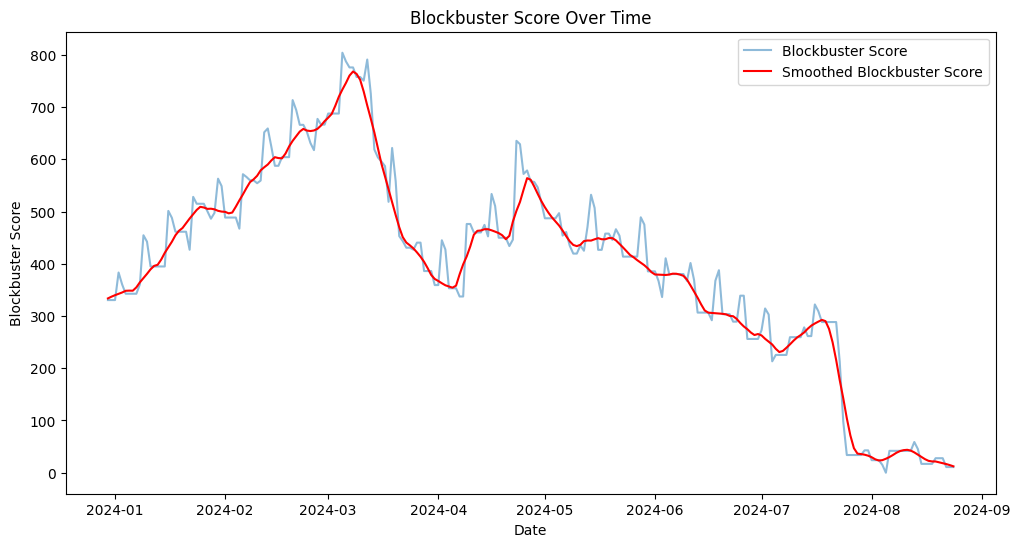

In [11]:
# plot blockbuster_score and blockbuster_score_smoothed
plt.figure(figsize=(12, 6))
plt.plot(ts_movies_on_air['date'], ts_movies_on_air['blockbuster_score'], label='Blockbuster Score', alpha=0.5)
plt.plot(ts_movies_on_air['date'], ts_movies_on_air['blockbuster_score_smoothed'], label='Smoothed Blockbuster Score', color='red')
plt.xlabel('Date')
plt.ylabel('Blockbuster Score')
plt.title('Blockbuster Score Over Time')
plt.legend()
plt.show()

### Kids

In [12]:
# append pricebook to trx
df_transactions = df_transactions.merge(df_pricebook, how='left', on='ID_CINE')

# get if the trx contained children tickets
df_transactions = (
    df_transactions
    .assign(
        had_children_ticket=lambda x: np.where(
            (x['IMPORTE_TAQUILLA'] / x['BOLETOS']).lt(x['PRECIO_POL_R']),
            1,
            0
        ),
        has_children=lambda x: x.groupby('CARD_MEMBERSHIPID')['had_children_ticket'].transform(
            lambda y: y.any().astype(int)
        )
    )
)

# look
print(f"Total trx with kids: {df_transactions['had_children_ticket'].sum()}")
print(f"Percentage of trx with kids: {df_transactions['had_children_ticket'].mean() * 100:.2f}%")
print("Shape:", df_transactions.shape)
df_transactions.head()

Total trx with kids: 202846
Percentage of trx with kids: 66.68%
Shape: (304196, 12)


,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,PRECIO_POL_R,had_children_ticket,has_children
0,9610a0e3-a813-5c2f-a25a-9ba3b3e033fa,234,2024-01-01,2024-01-01,49026ebf4714f93dcb5f9ae0230c4d4f9afb424d1c23da...,1,AQUAMAN Y EL REINO PERDIDO,2,82.0,75.0,1,1
1,01984a03-5ec3-54e0-8696-d4622a181411,154,2024-01-01,2024-01-01,df624cc8bc0be3e8cb3de3522bf0f2728f6a88b5fe451e...,1,GODZILLA MINUS ONE,1,70.0,83.0,1,1
2,7b45b02a-a47b-506d-878a-79fde2bf8821,273,2024-01-01,2024-01-01,dc8f5462dfa0b2f78e04d6ae96f2bb597a7725c24a0b4a...,1,AQUAMAN Y EL REINO PERDIDO,2,82.0,75.0,1,1
3,8e9b0dc9-56f3-57c7-991d-f588c9712b7c,260,2024-01-01,2024-01-01,60b3ba400a6d9671cfe62a7114e415eae0e1af4e1ce738...,1,WONKA,2,82.0,62.0,1,1
4,eabdde26-84fd-58fb-8cc0-9fe46a839e57,273,2024-01-01,2024-01-02,2a81492ebbbdf24a683736eddd436e9430d43101acbdf4...,1,AQUAMAN Y EL REINO PERDIDO,2,170.0,75.0,0,0


### Time series of trx by client

In [13]:
# append the number of visits the user had before this trx
df_transactions = (
    df_transactions
    .sort_values(by=['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION'], ignore_index=True)
    .assign(
        cum_visits=lambda x: x.groupby('CARD_MEMBERSHIPID')['transaction_id'].cumcount() + 1,
        cum_spend=lambda x: x.groupby('CARD_MEMBERSHIPID')['IMPORTE_TAQUILLA'].cumsum(),
        avg_spend_per_visit=lambda x: x.groupby('CARD_MEMBERSHIPID')['IMPORTE_TAQUILLA'].transform('mean'),
        total_visits=lambda x: x.groupby('CARD_MEMBERSHIPID')['transaction_id'].transform('count'),
    )
    .sort_values(['total_visits', 'CARD_MEMBERSHIPID', 'FECHA_TRANSACCION'], ascending=[False, True, True], ignore_index=True)
)

# look
df_transactions.head(50)

,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,PRECIO_POL_R,had_children_ticket,has_children,cum_visits,cum_spend,avg_spend_per_visit,total_visits
0,97315cc5-bb5e-58e1-a101-8a06cea3bb2e,334,2024-01-08,2024-01-08,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,WONKA,8,300.0,67.0,1,1,1,300.0,264.105263,19
1,ca50d66b-10ae-522b-828c-997b0d19d80b,334,2024-02-04,2024-02-04,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,ARGYLLE: AGENTE SECRETO,9,510.0,67.0,1,1,2,810.0,264.105263,19
2,e1834005-bb5f-59de-80dd-835c72769d17,334,2024-02-14,2024-02-14,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,HÉROE POR ENCARGO,2,106.0,67.0,1,1,3,916.0,264.105263,19
3,ccf15526-4e4e-5327-918f-887a4eb63eee,334,2024-03-20,2024-03-20,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,KUNG FU PANDA 4,2,140.0,67.0,0,1,4,1056.0,264.105263,19
4,9f29859d-2180-5140-b28e-844523812eca,334,2024-03-29,2024-03-29,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,GODZILLA Y KONG:EL NUEVO IMPERIO,2,130.0,67.0,1,1,5,1186.0,264.105263,19
5,32128acc-300b-54a9-9d24-776a895c8dcd,334,2024-04-14,2024-04-14,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,GODZILLA Y KONG:EL NUEVO IMPERIO,10,646.0,67.0,1,1,6,1832.0,264.105263,19
6,b3753a58-f430-5fac-b4e8-c2428ad04cf7,334,2024-04-20,2024-04-20,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,GODZILLA Y KONG:EL NUEVO IMPERIO,2,116.0,67.0,1,1,7,1948.0,264.105263,19
7,8558b423-e92b-5fa9-a4c7-d8a89cfefad7,334,2024-04-22,2024-04-22,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,ABIGAIL,5,175.0,67.0,1,1,8,2123.0,264.105263,19
8,b4d32226-f5c6-5a11-8d02-12ed118c3070,334,2024-04-27,2024-04-27,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,GODZILLA Y KONG:EL NUEVO IMPERIO,2,136.0,67.0,0,1,9,2259.0,264.105263,19
9,79124298-3b9f-5343-9846-1035f96d3053,334,2024-04-28,2024-04-28,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,ARTHUR: UNA AMISTAD SIN LÍMITES,1,68.0,67.0,0,1,10,2327.0,264.105263,19


### Favorite Cinema

In [14]:
# get their favorite cinema
df_transactions['favorite_cinema'] = (
    df_transactions
    .groupby('CARD_MEMBERSHIPID')['ID_CINE']
    .transform(lambda x: x.mode()[0] if not x.mode().empty else None)
)

# look
df_transactions.head()

,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,PRECIO_POL_R,had_children_ticket,has_children,cum_visits,cum_spend,avg_spend_per_visit,total_visits,favorite_cinema
0,97315cc5-bb5e-58e1-a101-8a06cea3bb2e,334,2024-01-08,2024-01-08,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,WONKA,8,300.0,67.0,1,1,1,300.0,264.105263,19,334
1,ca50d66b-10ae-522b-828c-997b0d19d80b,334,2024-02-04,2024-02-04,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,ARGYLLE: AGENTE SECRETO,9,510.0,67.0,1,1,2,810.0,264.105263,19,334
2,e1834005-bb5f-59de-80dd-835c72769d17,334,2024-02-14,2024-02-14,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,HÉROE POR ENCARGO,2,106.0,67.0,1,1,3,916.0,264.105263,19,334
3,ccf15526-4e4e-5327-918f-887a4eb63eee,334,2024-03-20,2024-03-20,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,KUNG FU PANDA 4,2,140.0,67.0,0,1,4,1056.0,264.105263,19,334
4,9f29859d-2180-5140-b28e-844523812eca,334,2024-03-29,2024-03-29,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,GODZILLA Y KONG:EL NUEVO IMPERIO,2,130.0,67.0,1,1,5,1186.0,264.105263,19,334


---
# ADT Building

## Expand emails to days before and after K

In [146]:
# Step 1: For each email, create +/- K rows, where K is the number of days before and after the email date, also change the EventDate to the new date
K = 7  # number of days before and after the email date
df_emails_expanded = (
    df_emails
    # only emails between 2024-01-01 and 2024-07-15
    .loc[
        lambda x: 
            (x['EventDate'] >= pd.to_datetime('2024-01-01').date()) &
            (x['EventDate'] <= pd.to_datetime('2024-07-15').date())
    ]
    .assign(
        EventDate=lambda x: pd.to_datetime(x['EventDate'], format='%Y-%m-%d', errors='coerce'),
        dates_to_expand=lambda x: x['EventDate'].apply(lambda d: pd.date_range(start=d - pd.Timedelta(days=K), end=d + pd.Timedelta(days=K), freq='D'))
    )
    .loc[:, ['CARD_MEMBERSHIPID', 'SendId', 'dates_to_expand']]
    .explode('dates_to_expand')
    .reset_index(drop=True)
    .rename(columns={'dates_to_expand': 'EventDate'})
)

# look size
print(f"Emails expanded shape: {df_emails_expanded.shape}")
df_emails_expanded.head(17)

Emails expanded shape: (5074890, 3)


,CARD_MEMBERSHIPID,SendId,EventDate
0,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-13
1,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-14
2,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-15
3,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-16
4,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-17
5,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-18
6,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-19
7,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-20
8,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-21
9,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-22


In [147]:
# Step 2: Generate a number between -K and K to indicate how many days before or after the email date this row is
df_emails_expanded = (
    df_emails_expanded
    .assign(
        days_from_email=lambda x: x.groupby('CARD_MEMBERSHIPID').cumcount() - K
    )
    .query("days_from_email.between(-@K, @K)")
    .reset_index(drop=True)
)

# look
print("min and max days_from_email:", df_emails_expanded['days_from_email'].min(), df_emails_expanded['days_from_email'].max())
print("Emails expanded shape after adding days_from_email:", df_emails_expanded.shape)
df_emails_expanded.head(17)


min and max days_from_email: -7 7
Emails expanded shape after adding days_from_email: (4891200, 4)


,CARD_MEMBERSHIPID,SendId,EventDate,days_from_email
0,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-13,-7
1,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-14,-6
2,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-15,-5
3,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-16,-4
4,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-17,-3
5,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-18,-2
6,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-19,-1
7,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-20,0
8,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-21,1
9,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-22,2


## Addorn

In [148]:
# Step 3: Append the blugbuster_score_smoothed for that date
df_emails_expanded = (
    df_emails_expanded
    .merge(
        ts_movies_on_air[['date', 'blockbuster_score']],
        how='left',
        left_on='EventDate',
        right_on='date'
    )
    .drop(columns=['date'])
    # eliminate rows with eventdate less than 2024-01-01 or greater than 2024-07-15
    .loc[
        lambda x: 
            (x['EventDate'] >= pd.to_datetime('2024-01-01')) &
            (x['EventDate'] <= pd.to_datetime('2024-07-15'))
    ]
    .reset_index(drop=True)
)

# look
print(df_emails_expanded.shape)
df_emails_expanded.head()

(4840962, 5)


,CARD_MEMBERSHIPID,SendId,EventDate,days_from_email,blockbuster_score
0,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-13,-7,306.612852
1,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-14,-6,306.612852
2,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-15,-5,306.612852
3,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-16,-4,306.612852
4,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-17,-3,291.931504


In [149]:
# Step 4: Generate cycles
df_emails_expanded = df_emails_expanded.assign(
    # categorical
    weekday=lambda x: x['EventDate'].dt.day_name(),
    monthday=lambda x: x['EventDate'].dt.day,
    is_holiday=lambda x: x['EventDate'].isin(df_mx_holidays['date']).astype(int),
    is_release_day=lambda x: x['EventDate'].isin(df_releases['ESTRENO']).astype(int),
    # cycles using fourier series
    sin_weekday=lambda x: np.sin(2 * np.pi * x['EventDate'].dt.weekday / 7),
    cos_weekday=lambda x: np.cos(2 * np.pi * x['EventDate'].dt.weekday / 7),
    sin_monthday=lambda x: np.sin(2 * np.pi * x['EventDate'].dt.day / 30.4),
    cos_monthday=lambda x: np.cos(2 * np.pi * x['EventDate'].dt.day / 30.4)
)

# look
df_emails_expanded.head()

,CARD_MEMBERSHIPID,SendId,EventDate,days_from_email,blockbuster_score,weekday,monthday,is_holiday,is_release_day,sin_weekday,cos_weekday,sin_monthday,cos_monthday
0,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-13,-7,306.612852,Thursday,13,0,1,0.433884,-0.900969,0.439197,-0.898391
1,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-14,-6,306.612852,Friday,14,0,1,-0.433884,-0.900969,0.245485,-0.969400
2,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-15,-5,306.612852,Saturday,15,0,0,-0.974928,-0.222521,0.041325,-0.999146
3,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-16,-4,306.612852,Sunday,16,0,0,-0.781831,0.623490,-0.164595,-0.986361
4,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-17,-3,291.931504,Monday,17,0,0,0.000000,1.000000,-0.363508,-0.931591


In [150]:
# Step 5: Merge with transactions
df_emails_expanded = (
    df_emails_expanded
    .merge(
        (
            df_transactions
            .loc[:, ['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION', 'has_children', 'total_visits', 'avg_spend_per_visit', 'favorite_cinema', 'transaction_id']]
            ),
        how='left',
        left_on=['CARD_MEMBERSHIPID', 'EventDate'],
        right_on=['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION']
    )
    .drop(columns=['FECHA_TRANSACCION'])
    .assign(
        has_bought=lambda x: np.where(x['transaction_id'].notna(), 1, 0)
    )
)

# look
print(df_emails_expanded.shape)
print(f"Total boughts: {df_emails_expanded['has_bought'].sum()}")

(4840962, 19)
Total boughts: 1470


In [151]:
# look at a specific user
df_emails_expanded.query("CARD_MEMBERSHIPID == '960db10b5adf187481399e792e7593e7176ddd70f0a24fdc9426a6e9d0c35ff8'")

,CARD_MEMBERSHIPID,SendId,EventDate,days_from_email,blockbuster_score,weekday,monthday,is_holiday,is_release_day,sin_weekday,cos_weekday,sin_monthday,cos_monthday,has_children,total_visits,avg_spend_per_visit,favorite_cinema,transaction_id,has_bought
1215,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-13,-7,306.612852,Thursday,13,0,1,0.433884,-0.900969,0.439197,-0.898391,NaN,NaN,NaN,NaN,NaN,0
1216,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-14,-6,306.612852,Friday,14,0,1,-0.433884,-0.900969,0.245485,-0.969400,NaN,NaN,NaN,NaN,NaN,0
1217,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-15,-5,306.612852,Saturday,15,0,0,-0.974928,-0.222521,0.041325,-0.999146,0.0,1.0,70.0,333.0,2daac283-badf-5964-9142-b65c3aba9edf,1
1218,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-16,-4,306.612852,Sunday,16,0,0,-0.781831,0.623490,-0.164595,-0.986361,NaN,NaN,NaN,NaN,NaN,0
1219,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-17,-3,291.931504,Monday,17,0,0,0.000000,1.000000,-0.363508,-0.931591,NaN,NaN,NaN,NaN,NaN,0
1220,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-18,-2,367.590166,Tuesday,18,0,0,0.781831,0.623490,-0.546948,-0.837166,NaN,NaN,NaN,NaN,NaN,0
1221,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-19,-1,387.796253,Wednesday,19,0,0,0.974928,-0.222521,-0.707107,-0.707107,NaN,NaN,NaN,NaN,NaN,0
1222,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-20,0,303.656316,Thursday,20,0,1,0.433884,-0.900969,-0.837166,-0.546948,NaN,NaN,NaN,NaN,NaN,0
1223,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-21,1,303.656316,Friday,21,0,1,-0.433884,-0.900969,-0.931591,-0.363508,NaN,NaN,NaN,NaN,NaN,0
1224,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-22,2,303.656316,Saturday,22,0,0,-0.974928,-0.222521,-0.986361,-0.164595,NaN,NaN,NaN,NaN,NaN,0


## BFill & FFill

In [152]:
# bfill and ffill the has_children, cum_visits, avg_spend_per_visit, favorite_cinema per user, each time it has a new purchase
df_emails_expanded = (
    df_emails_expanded
    .sort_values(by=['CARD_MEMBERSHIPID', 'EventDate'], ignore_index=True)
    .assign(
        # all
        has_children=lambda x: x.groupby('CARD_MEMBERSHIPID')['has_children'].ffill().bfill(),
        avg_spend_per_visit=lambda x: x.groupby('CARD_MEMBERSHIPID')['avg_spend_per_visit'].ffill().bfill(),
        favorite_cinema=lambda x: x.groupby('CARD_MEMBERSHIPID')['favorite_cinema'].ffill().bfill(),
        # ffill only cum_visits
        total_visits=lambda x: x.groupby('CARD_MEMBERSHIPID')['total_visits'].ffill().bfill()
    )
)

In [153]:
# look at a specific user
df_emails_expanded.query("CARD_MEMBERSHIPID == '960db10b5adf187481399e792e7593e7176ddd70f0a24fdc9426a6e9d0c35ff8'")

,CARD_MEMBERSHIPID,SendId,EventDate,days_from_email,blockbuster_score,weekday,monthday,is_holiday,is_release_day,sin_weekday,cos_weekday,sin_monthday,cos_monthday,has_children,total_visits,avg_spend_per_visit,favorite_cinema,transaction_id,has_bought
2838374,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-13,-7,306.612852,Thursday,13,0,1,0.433884,-0.900969,0.439197,-0.898391,0.0,1.0,70.0,333.0,NaN,0
2838375,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-14,-6,306.612852,Friday,14,0,1,-0.433884,-0.900969,0.245485,-0.969400,0.0,1.0,70.0,333.0,NaN,0
2838376,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-15,-5,306.612852,Saturday,15,0,0,-0.974928,-0.222521,0.041325,-0.999146,0.0,1.0,70.0,333.0,2daac283-badf-5964-9142-b65c3aba9edf,1
2838377,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-16,-4,306.612852,Sunday,16,0,0,-0.781831,0.623490,-0.164595,-0.986361,0.0,1.0,70.0,333.0,NaN,0
2838378,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-17,-3,291.931504,Monday,17,0,0,0.000000,1.000000,-0.363508,-0.931591,0.0,1.0,70.0,333.0,NaN,0
2838379,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-18,-2,367.590166,Tuesday,18,0,0,0.781831,0.623490,-0.546948,-0.837166,0.0,1.0,70.0,333.0,NaN,0
2838380,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-19,-1,387.796253,Wednesday,19,0,0,0.974928,-0.222521,-0.707107,-0.707107,0.0,1.0,70.0,333.0,NaN,0
2838381,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-20,0,303.656316,Thursday,20,0,1,0.433884,-0.900969,-0.837166,-0.546948,0.0,1.0,70.0,333.0,NaN,0
2838382,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-21,1,303.656316,Friday,21,0,1,-0.433884,-0.900969,-0.931591,-0.363508,0.0,1.0,70.0,333.0,NaN,0
2838383,960db10b5adf187481399e792e7593e7176ddd70f0a24f...,1456917,2024-06-22,2,303.656316,Saturday,22,0,0,-0.974928,-0.222521,-0.986361,-0.164595,0.0,1.0,70.0,333.0,NaN,0


## Design Variables

In [154]:
# Step 6: Design variables
df_emails_expanded = df_emails_expanded.assign(
    # design variables
    is_post= lambda x: x['days_from_email'].gt(0).astype(int),
    r=lambda x: np.where(x['days_from_email'].gt(0), x['days_from_email'], 0),  # days after email
    # triangular kernel weights
    w=lambda x: 1 - x['days_from_email'].abs() / (K + 1),  # K + 1 to avoid division by zero
    )

# look
df_emails_expanded.head(15)

,CARD_MEMBERSHIPID,SendId,EventDate,days_from_email,blockbuster_score,weekday,monthday,is_holiday,is_release_day,sin_weekday,...,cos_monthday,has_children,total_visits,avg_spend_per_visit,favorite_cinema,transaction_id,has_bought,is_post,r,w
0,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-15,-7,507.101398,Wednesday,15,0,1,0.974928,...,-0.999146,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.125
1,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-16,-6,426.795906,Thursday,16,0,1,0.433884,...,-0.986361,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.250
2,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-17,-5,426.795906,Friday,17,0,0,-0.433884,...,-0.931591,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.375
3,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-18,-4,457.851658,Saturday,18,0,1,-0.974928,...,-0.837166,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.500
4,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-19,-3,457.851658,Sunday,19,0,0,-0.781831,...,-0.707107,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.625
5,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-20,-2,445.903290,Monday,20,0,1,0.000000,...,-0.546948,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.750
6,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-21,-1,466.239845,Tuesday,21,0,0,0.781831,...,-0.363508,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.875
7,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-22,0,453.957046,Wednesday,22,0,0,0.974928,...,-0.164595,1.0,3.0,45.833333,306.0,NaN,0,0,0,1.000
8,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-23,1,413.771560,Thursday,23,0,1,0.433884,...,0.041325,1.0,3.0,45.833333,306.0,NaN,0,1,1,0.875
9,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-24,2,413.771560,Friday,24,0,0,-0.433884,...,0.245485,1.0,3.0,45.833333,306.0,NaN,0,1,2,0.750


In [155]:
# Step 7: Eliminate rows where days_from_email is 0 (the email day)
df_emails_expanded = df_emails_expanded.query("days_from_email != 0").reset_index(drop=True)

# print size
print(df_emails_expanded.shape)

(4514882, 22)


In [156]:
# look hom many has_bought in number and %
print(f"Total has_bought: {df_emails_expanded['has_bought'].sum()}")
print(f"Percentage has_bought: {df_emails_expanded['has_bought'].mean() * 100:.4f}%")

# look % of is_post
print(f"Percentage is_post: {df_emails_expanded['is_post'].mean() * 100:.4f}%")

Total has_bought: 1394
Percentage has_bought: 0.0309%
Percentage is_post: 50.1959%


---
# Estimate Effect of Emails on Movie Purchases

## P1: ML Model

### Data Structures

In [181]:
# Create X, y and w
# X
cols2use = [
    'blockbuster_score',
    'is_holiday',
    # 'is_release_day',
    'sin_weekday',
    'cos_weekday',
    'sin_monthday',
    'cos_monthday',
    'has_children',
    'total_visits',
    # 'avg_spend_per_visit',
    'favorite_cinema',
    'SendId',
    'is_post',

    # 'r'
]
cat_cols = [
    'is_post',
    'is_holiday',
    # 'is_release_day',
    'has_children',
    'favorite_cinema',
    'SendId'
]
X = df_emails_expanded[cols2use].copy()

# to categorical
X['has_children'] = X['has_children'].fillna(-1).astype(int)
X['is_post'] = X['is_post'].astype(int)
X['is_holiday'] = X['is_holiday'].astype(int)
# X['is_release_day'] = X['is_release_day'].astype(int)
X['favorite_cinema'] = X['favorite_cinema'].fillna(-1).astype(int)
X['SendId'] = X['SendId'].astype(str)

X[cat_cols] = X[cat_cols].astype('category')

# w
w_weights = df_emails_expanded['w'].copy()

# y
y = df_emails_expanded['has_bought'].copy()

In [182]:
# get nan values
X.isna().sum()

blockbuster_score       0
is_holiday              0
sin_weekday             0
cos_weekday             0
sin_monthday            0
cos_monthday            0
has_children            0
total_visits         1925
favorite_cinema         0
SendId                  0
is_post                 0
dtype: int64

In [183]:
# split
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
    X, y, w_weights, test_size=0.2, random_state=42, stratify=X['is_post']
)

# print shapes
print(f"Train size: {X_train.shape}, Val size: {X_val.shape}")

Train size: (3611905, 11), Val size: (902977, 11)


In [184]:
# pools
pool_train = Pool(X_train, y_train, weight=w_train, cat_features=cat_cols)
pool_val = Pool(X_val, y_val, weight=w_val, cat_features=cat_cols)


### Train

In [185]:
# train CatBoost model
model = CatBoostClassifier(
    loss_function="Logloss",
    # eval_metric="Recall",
    random_seed=42,
    verbose=100,
    learning_rate=0.1,
)

# train model
model.fit(pool_train, eval_set=pool_val, early_stopping_rounds=50)

0:	learn: 0.3700557	test: 0.3700374	best: 0.3700374 (0)	total: 404ms	remaining: 6m 43s
100:	learn: 0.0028136	test: 0.0027027	best: 0.0027012 (82)	total: 28.8s	remaining: 4m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.002701211631
bestIteration = 82

Shrink model to first 83 iterations.


In [186]:
# get classification report
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred, target_names=['Not Bought', 'Bought'], digits=4))


              precision    recall  f1-score   support

  Not Bought     0.9997    1.0000    0.9999    902713
      Bought     0.0000    0.0000    0.0000       264

    accuracy                         0.9997    902977
   macro avg     0.4999    0.5000    0.4999    902977
weighted avg     0.9994    0.9997    0.9996    902977



/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Shap

In [187]:
# get shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

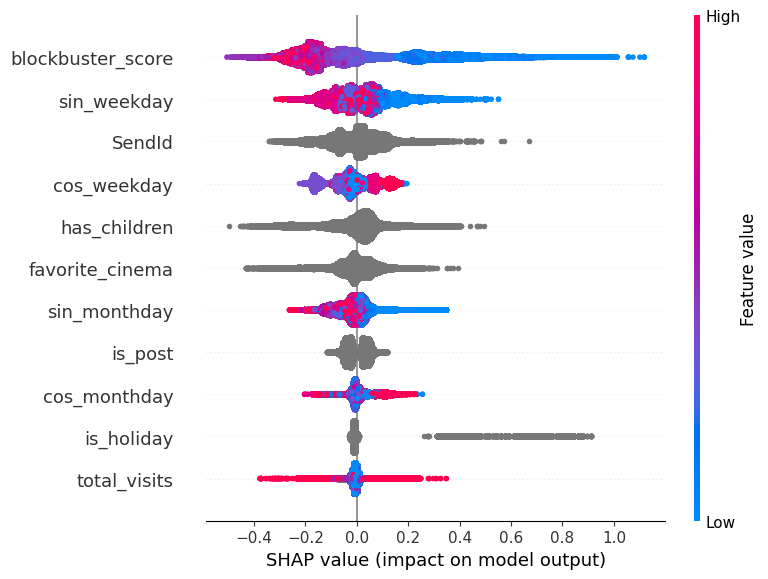

In [188]:
# plot shap values
shap.summary_plot(shap_values, X_val, plot_type="dot", max_display=20)


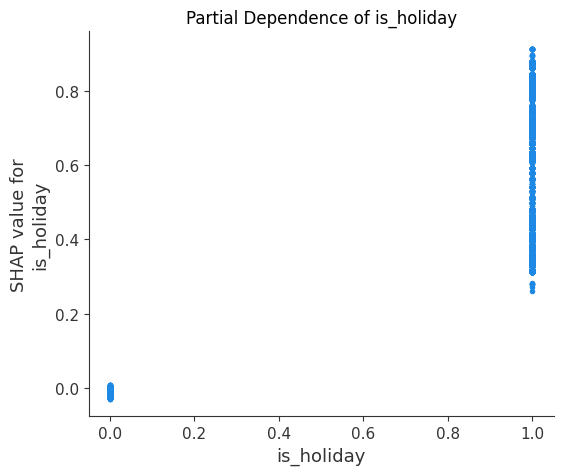

In [196]:
# see the partial dependence of is_post
shap.dependence_plot('is_holiday', shap_values, X_val, interaction_index=None,show=False)
plt.title('Partial Dependence of is_holiday')
plt.show()

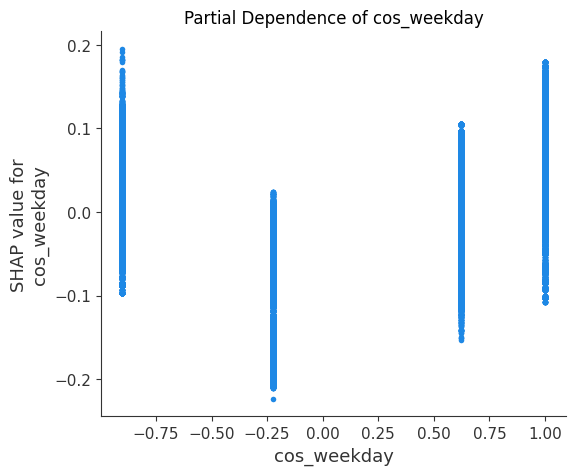

In [189]:
# see the partial dependence of is_post
shap.dependence_plot('cos_weekday', shap_values, X_val, interaction_index=None,show=False)
plt.title('Partial Dependence of cos_weekday')
plt.show()

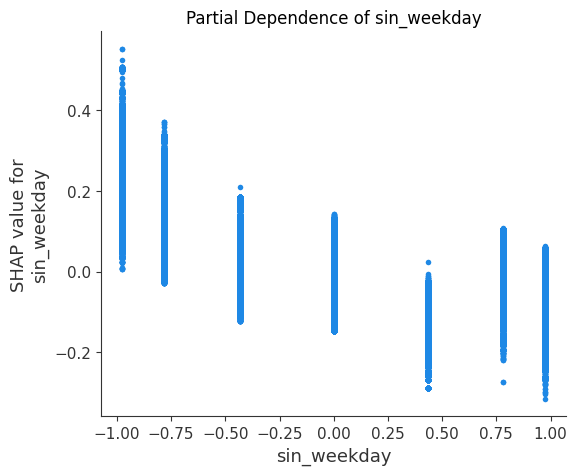

In [190]:
# see the partial dependence of is_post
shap.dependence_plot('sin_weekday', shap_values, X_val, interaction_index=None,show=False)
plt.title('Partial Dependence of sin_weekday')
plt.show()

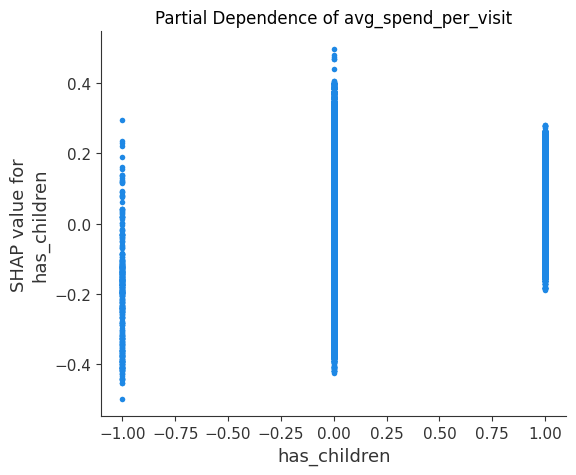

In [191]:
# see the partial dependence of is_post
shap.dependence_plot('has_children', shap_values, X_val, interaction_index=None,show=False)
plt.title('Partial Dependence of avg_spend_per_visit')
plt.show()

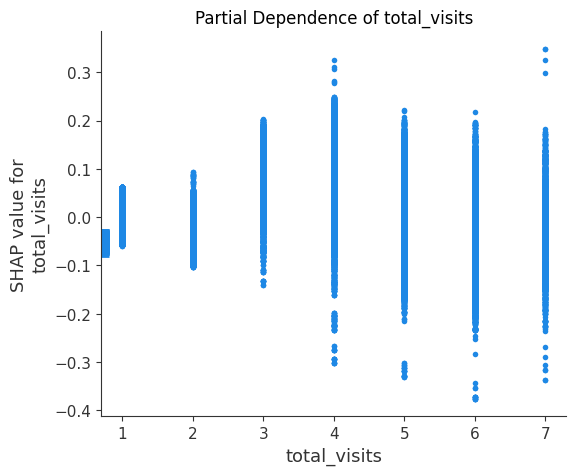

In [192]:
# see the partial dependence of is_post
shap.dependence_plot('total_visits', shap_values, X_val, interaction_index=None,show=False)
plt.title('Partial Dependence of total_visits')
plt.show()

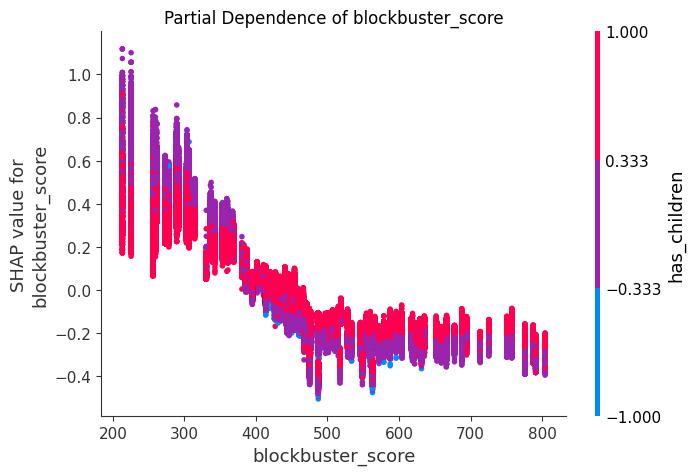

In [195]:
# see the partial dependence of is_post
shap.dependence_plot('blockbuster_score', shap_values, X_val,  show=False)
plt.title('Partial Dependence of blockbuster_score')
plt.show()

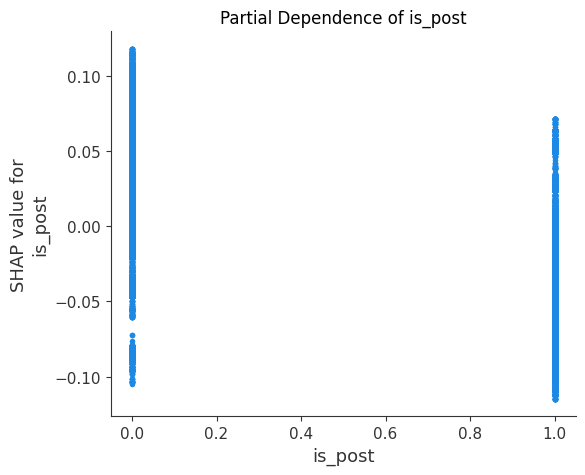

In [194]:
# see the partial dependence of is_post
shap.dependence_plot('is_post', shap_values, X_val, interaction_index=None, show=False)
plt.title('Partial Dependence of is_post')
plt.show()

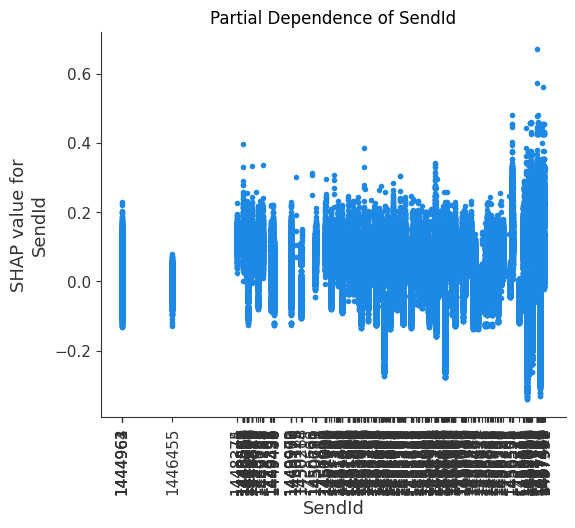

In [198]:
# see the partial dependence of SendId
shap.dependence_plot('SendId', shap_values, X_val, interaction_index=None, show=False)
plt.title('Partial Dependence of SendId')
plt.show()

^^^ looks like sending emails is counterproductive, but not that big

## P2: RDD

### Formula

In [211]:
# get if is weekend, wednesday or any other day
df_emails_expanded['type_of_day'] = np.where(
    df_emails_expanded['EventDate'].dt.weekday.isin([5, 6]), 'weekend',
    np.where(df_emails_expanded['EventDate'].dt.weekday == 2, 'wednesday', 'other')
)

In [236]:
# formula of the RDD
formula = "has_bought ~ is_post + C(type_of_day, Treatment('other')) + is_holiday"

# look
formula

"has_bought ~ is_post + C(type_of_day, Treatment('other')) + is_holiday"

In [237]:
# look nans of the features in the formula
df_emails_expanded[["is_post", "weekday", "is_holiday", "has_children"]].isna().sum()

# has_childern fillna 0
df_emails_expanded['has_children'] = df_emails_expanded['has_children'].fillna(0).astype(int)

### Fit

In [238]:
# fit the RDD model
rdd_model = smf.glm(
    formula,
    data=df_emails_expanded,
    family=sm.families.Binomial()
)

# fit the model with cluster robust standard errors
glm_res = rdd_model.fit(cov_type='cluster', cov_kwds={'groups': df_emails_expanded['CARD_MEMBERSHIPID']})


In [248]:
# look
print(glm_res.summary())
print("RD jump (is_post) on log-odds scale:", glm_res.params['is_post'])
print("RD jump (is_post) on probability scale:", np.exp(glm_res.params['is_post']))

                 Generalized Linear Model Regression Results                  
Dep. Variable:             has_bought   No. Observations:              4514882
Model:                            GLM   Df Residuals:                  4514877
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12633.
Date:                Sun, 10 Aug 2025   Deviance:                       25265.
Time:                        13:28:14   Pearson chi2:                 4.52e+06
No. Iterations:                    12   Pseudo R-squ. (CS):          1.275e-05
Covariance Type:              cluster                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

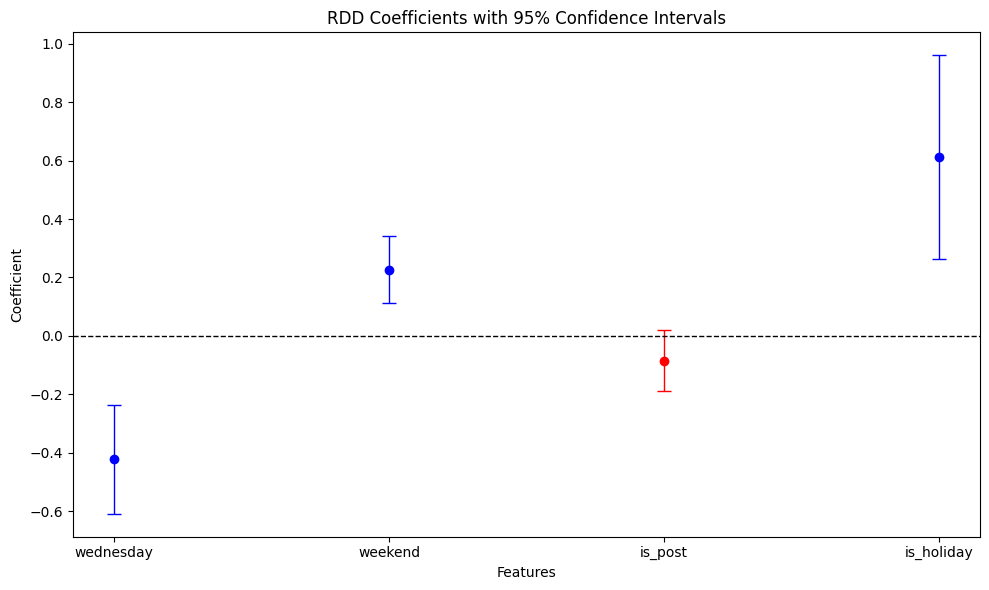

In [268]:
# plot coefficients with confidence intervals
coef_df = pd.DataFrame({
    'feature': glm_res.params.index,
    'coef': glm_res.params.values,
    'conf_int_lower': glm_res.conf_int()[0],
    'conf_int_upper': glm_res.conf_int()[1],
    'p_value': glm_res.pvalues.values
})
coef_df = coef_df[coef_df['feature'] != 'Intercept']  # remove intercept

# tidy type of day: C(type_of_day, Treatment('other'))[T.wednesday] to wednesday, C(type_of_day, Treatment('other'))[T.weekend] to weekend
coef_df['feature'] = coef_df['feature'].str.replace(r"C\(type_of_day, Treatment\('other'\)\)\[T\.", '', regex=True)
coef_df['feature'] = coef_df['feature'].str.replace(r"\]", '', regex=True)

# color mapping for features if p_value < 0.05
coef_df['color'] = np.where(coef_df['p_value'] < 0.05, 'blue', 'red')

# plt
plt.figure(figsize=(10, 6))
for _, row in coef_df.iterrows():
    plt.errorbar(
        row['feature'],
        row['coef'],
        yerr=[[row['coef'] - row['conf_int_lower']], [row['conf_int_upper'] - row['coef']]],
        fmt='o',
        color=row['color'],
        capsize=5,
        elinewidth=1,
        markeredgewidth=1
    )
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xticks(rotation=0)
plt.title('RDD Coefficients with 95% Confidence Intervals')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.tight_layout()
plt.show()


It looks like there is no effect of the email on the probability of buying a ticket

In [269]:
# predict on set
y_pred = glm_res.predict(df_emails_expanded)

In [ ]:
y_pred.gt(0.5).mean()  # no row can be predicted

np.float64(0.0)

# Future Work

Future work:
- With this data:
    - use a bayesian model to get the uncertainty of the RDD jump
    - weight more the days when there is a purchase
    - Address the question of why the relationship between blockbuster score and has_bought is negative

- In general:
    - Design an RCT test to prove causality of the email sent
    - Take into account the time of the day when the email was sent & if their is a holiday inbetween
    - Also it could be a geospatial analysis, sending emails to users that live in a certain city and have a city that doesn't send emails to their clients


---
# Sandbox

In [179]:
df_emails_expanded.columns

Index(['CARD_MEMBERSHIPID', 'SendId', 'EventDate', 'days_from_email',
       'blockbuster_score', 'weekday', 'monthday', 'is_holiday',
       'is_release_day', 'sin_weekday', 'cos_weekday', 'sin_monthday',
       'cos_monthday', 'has_children', 'total_visits', 'avg_spend_per_visit',
       'favorite_cinema', 'transaction_id', 'has_bought', 'is_post', 'r', 'w'],
      dtype='object')

In [90]:
df_emails_expanded

,CARD_MEMBERSHIPID,SendId,EventDate,days_from_email,blockbuster_score_smoothed,weekday,monthday,is_holiday,is_release_day,sin_weekday,...,cos_monthday,has_children,total_visits,avg_spend_per_visit,favorite_cinema,transaction_id,has_bought,is_post,r,w
0,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-15,-7,446.961220,Wednesday,15,0,1,0.974928,...,-0.999146,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.125
1,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-16,-6,449.162610,Thursday,16,0,1,0.433884,...,-0.986361,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.250
2,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-17,-5,447.054354,Friday,17,0,0,-0.433884,...,-0.931591,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.375
3,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-18,-4,446.996378,Saturday,18,0,1,-0.974928,...,-0.837166,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.500
4,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,1455958,2024-05-19,-3,449.346006,Sunday,19,0,0,-0.781831,...,-0.707107,1.0,3.0,45.833333,306.0,NaN,0,0,0,0.625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4514877,ffffd3a92fb51be3475e2883a3c19aa88224fa1a35678b...,1454551,2024-04-18,3,458.856372,Thursday,18,0,1,0.433884,...,-0.837166,NaN,NaN,NaN,NaN,NaN,0,1,3,0.625
4514878,ffffd3a92fb51be3475e2883a3c19aa88224fa1a35678b...,1454551,2024-04-19,4,454.660849,Friday,19,0,0,-0.433884,...,-0.707107,NaN,NaN,NaN,NaN,NaN,0,1,4,0.500
4514879,ffffd3a92fb51be3475e2883a3c19aa88224fa1a35678b...,1454551,2024-04-20,5,447.160051,Saturday,20,0,0,-0.974928,...,-0.546948,NaN,NaN,NaN,NaN,NaN,0,1,5,0.375
4514880,ffffd3a92fb51be3475e2883a3c19aa88224fa1a35678b...,1454551,2024-04-21,6,453.552317,Sunday,21,0,0,-0.781831,...,-0.363508,NaN,NaN,NaN,NaN,NaN,0,1,6,0.250


In [24]:
df_transactions.isna().sum()

transaction_id         0
ID_CINE                0
FECHA_TRANSACCION      0
FECHA_FUNCION          0
CARD_MEMBERSHIPID      0
ID_MARCA               0
TX_PELICULA_UNICA      0
BOLETOS                0
IMPORTE_TAQUILLA       0
PRECIO_POL_R           0
had_children_ticket    0
has_children           0
cum_visits             0
cum_spend              0
avg_spend_per_visit    0
total_visits           0
favorite_cinema        0
dtype: int64

In [25]:
df_transactions

,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,PRECIO_POL_R,had_children_ticket,has_children,cum_visits,cum_spend,avg_spend_per_visit,total_visits,favorite_cinema
0,97315cc5-bb5e-58e1-a101-8a06cea3bb2e,334,2024-01-08,2024-01-08,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,WONKA,8,300.0,67.0,1,1,1,300.0,264.105263,19,334
1,ca50d66b-10ae-522b-828c-997b0d19d80b,334,2024-02-04,2024-02-04,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,ARGYLLE: AGENTE SECRETO,9,510.0,67.0,1,1,2,810.0,264.105263,19,334
2,e1834005-bb5f-59de-80dd-835c72769d17,334,2024-02-14,2024-02-14,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,HÉROE POR ENCARGO,2,106.0,67.0,1,1,3,916.0,264.105263,19,334
3,ccf15526-4e4e-5327-918f-887a4eb63eee,334,2024-03-20,2024-03-20,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,KUNG FU PANDA 4,2,140.0,67.0,0,1,4,1056.0,264.105263,19,334
4,9f29859d-2180-5140-b28e-844523812eca,334,2024-03-29,2024-03-29,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,GODZILLA Y KONG:EL NUEVO IMPERIO,2,130.0,67.0,1,1,5,1186.0,264.105263,19,334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304191,eb2e5ba9-a953-5d26-abc7-54cb1fa585b3,233,2024-03-30,2024-03-31,fffef85a6e87fe72de7375a8af5a23cf872d222d44e7e4...,1,GODZILLA Y KONG:EL NUEVO IMPERIO,3,240.0,72.0,0,0,1,240.0,240.000000,1,233
304192,a54aa95b-c16d-570e-b83c-dfc7a2de5381,233,2024-01-28,2024-01-28,ffff152876de205f010d43873ec99ebf10140ce27c016e...,1,EVIE: EL DEMONIO ENTRE NOSOTROS,1,54.0,72.0,1,1,1,54.0,54.000000,1,233
304193,50267da8-b8fd-508e-bfef-bcb1b98ca8b5,936,2024-03-23,2024-03-23,ffff410ea0698ec69646c1aafa2a77701f689f0353decb...,1,ALICIA EN EL PAÍS DE LAS PESADILLAS,1,100.0,96.0,0,0,1,100.0,100.000000,1,936
304194,2ebe2876-0c47-58d8-a2a1-0a21dd813b2f,318,2024-05-05,2024-05-05,ffff5fda5a1e2b34873d8d60fc0931e93d199dae49c359...,1,JUGAREMOS EN EL BOSQUE,2,144.0,74.0,1,1,1,144.0,144.000000,1,318


In [259]:
coef_df

,feature,coef,conf_int_lower,conf_int_upper,p_value,color
"C(type_of_day, Treatment('other'))[T.wednesday]",wednesday,-0.422081,-0.608554,-0.235608,0.000009,red
"C(type_of_day, Treatment('other'))[T.weekend]",weekend,0.226433,0.112544,0.340321,0.000097,red
is_post,is_post,-0.085504,-0.190307,0.019299,0.109809,blue
is_holiday,is_holiday,0.611556,0.262549,0.960562,0.000594,red


In [26]:
df_emails

,EventDate,SendId,CARD_MEMBERSHIPID,EventDate_TZ,EventDate_Hour
0,2023-11-29,1446643,742d12444044a3e9bb1a2cf6366a655a2d3c6aaf129ae4...,2023-11-29 13:47:54,13
1,2023-11-29,1446643,77469b9f0de8821ab678101074b4807419df2ac676922a...,2023-11-29 13:47:54,13
2,2023-11-29,1446643,ed5ba01b5c83153c264e40d0d402b180f8ac4479eac62b...,2023-11-29 13:47:56,13
3,2023-11-29,1446643,3fea058c49be5e3d22c004c1dfe0ec6b191d37529c452b...,2023-11-29 13:48:37,13
4,2023-11-29,1446629,d538badcacbedcc35868fe7b61edc3564362ab58152c28...,2023-11-29 11:45:14,11
...,...,...,...,...,...
478487,2024-05-04,1454286,b3e4bb24bc7a77772836a7586cde7ab1d5b6d72e2516f5...,2024-05-04 12:00:18,12
478488,2024-05-04,1454286,2d8b669ea3bdedc24eb41f49f43e843fb0eca69e8b6d0e...,2024-05-04 14:00:24,14
478489,2024-05-04,1454265,d96e76a8accd09a9e9e5f09d0ab4776176b3bc9819e074...,2024-05-04 21:00:08,21
478490,2024-05-04,1454286,4dbe45f3cac2a6d17b900c80bcf37ac8635d547796af90...,2024-05-04 14:00:20,14
